In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import copy
import math

Dans ce TP nous allons étudier un jeu de données correspodnant à des observations de température étalées sur tous les mois de différentes années $[1743 - 2020]$ pour la ville de Lyon. La source des données est la suivante :
'http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/45.81N-5.77E-TAVG-Trend.txt'

Pour chaque mois nous avons une mesure appelée *Anomaly*, celle ci correspond à la différence entre la température mesurée à ce moment là et une température moyenne fixée durant une période $1951$ à $1980$.

# 0. Import & clean up the datas 

La première étape consiste en l'importation de nos données. Ensuite nous devrons les 'nettoyer' car celles-ci contiennent un certain nombre de "NaN" notamment vers les années 1750 où il y avait un manque de données. 

Pour le nettoyage, nous ponvons "rogner" notre jeu de donnée, le faisant commencer en 1749 plutôt qu'en 1743. En effet c'est durant ces 6 années que nous avons le plus "NaN". Nous pouvons nous permettre d'effectuer cette opération car nous considérons que nous avons suffisament de points dans notre étude.

Ensuite nous devront effectuer une interpolation de nos données. Cela consiste à trouver une fonction qui mime ( ou qui "fit") au mieux nos points, afin de trouver des valeurs de températures à d'autres moments, c'est à dire obtenir plus de points entre nos points déja existants.

## 0.1 Import the datas :

In [3]:
data_file = "45.81N-5.77E-TAVG-Trend.txt"

In [4]:
# initialize lists
year = []
month = []
anomaly = []

In [5]:
# import data from txt file
with open(data_file, 'r', encoding = 'latin1') as f:
    reader = csv.reader(f)
    for line in reader:
        lin = line[0].split()
        if len(lin) == 12 and lin[0] != "%": # skip non-data lines
            year.append(float(lin[0]))
            month.append(float(lin[1]))
            anomaly.append(float(lin[2]))

In [6]:
# convert to numpy array
year = np.array(year)
month = np.array(month)
anomaly = np.array(anomaly)

In [7]:
date = year + (month-0.5)/12.0 # convert date to decimal year
print(date)

[1743.20833333 1743.29166667 1743.375      ... 2020.79166667 2020.875
 2020.95833333]


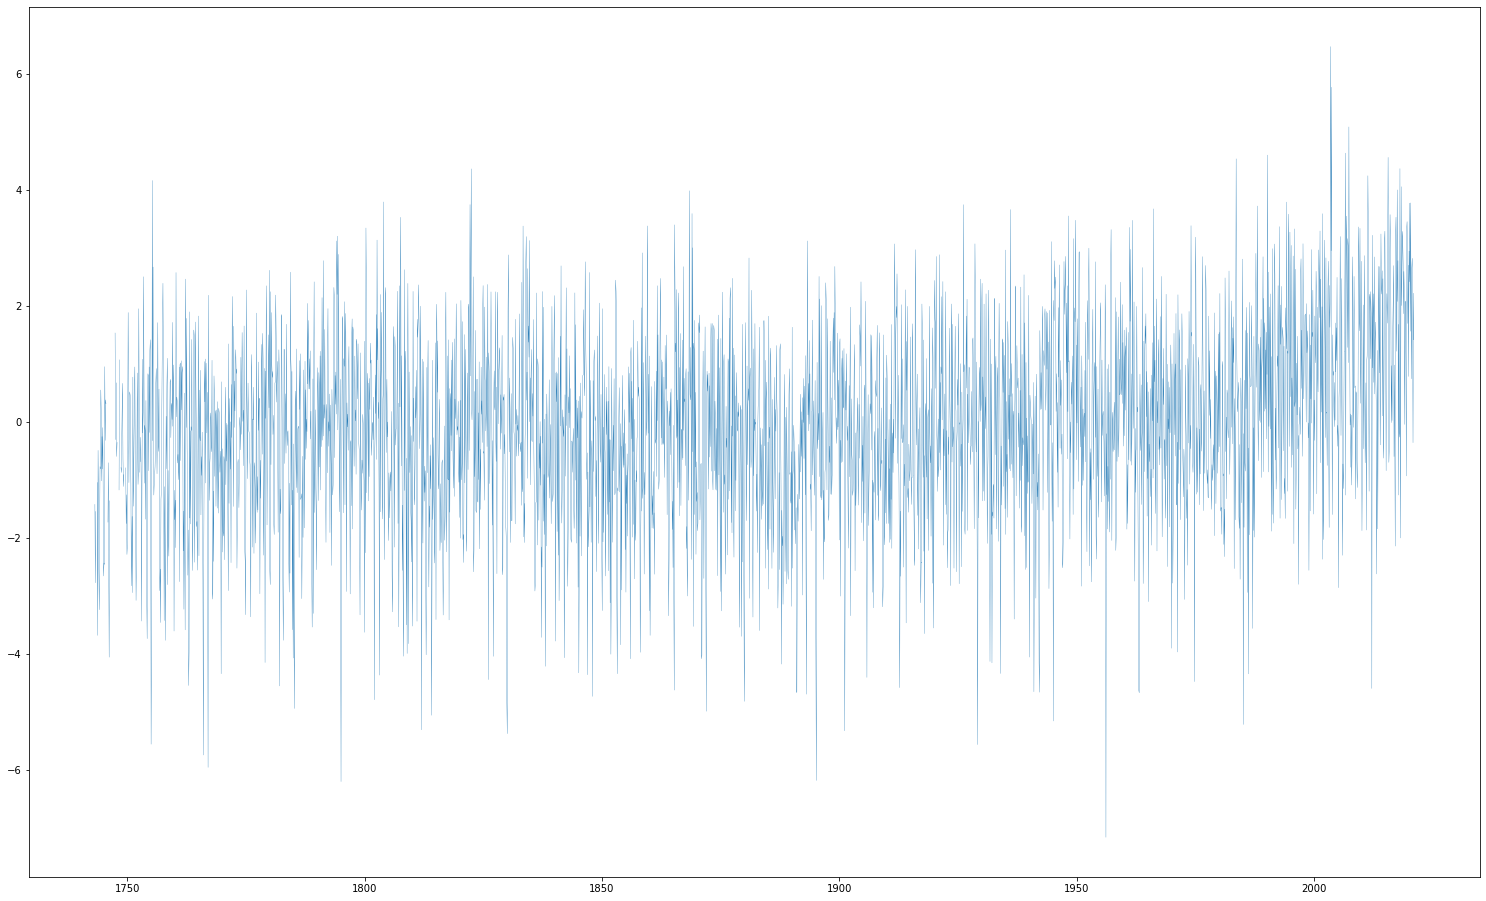

In [8]:
plt.figure(figsize=(26,16))
plt.plot(date,anomaly,linewidth=0.3)
plt.show()

## 0.2 Crop the time series for which most of the temperatures are available :

In [9]:
print (len(anomaly), len(date)) # the initial length of anomaly and date array

3334 3334


In [10]:
np.isnan(anomaly).sum() #total number of missing data in anomaly (NaN)

28

In [11]:
np.concatenate(np.argwhere(np.isnan(anomaly))) #All the indexes in the anomaly that have NaN

array([  3,   5,  29,  31,  32,  38,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  50,  53,  57,  58,  59,  60,  63,  64,  65,  74,  76,
        77, 114])

In [12]:
indexes2remove2 = np.concatenate([np.arange(0, 78), [114]])
indexes2remove2 #A list with all the line indexes we will remove because of the missing datas

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
       114])

In [13]:
anomaly2 = np.delete(anomaly, indexes2remove2) #We remove the missing datas from anomaly 
date2 = np.delete(date, indexes2remove2) #We have to do the same operation the date array 
np.isnan(anomaly2).sum() # We remove all the NaN missing data in our anomaly array

0

In [14]:
print (len(anomaly2), len(date2)) # same length

3255 3255


## 0.3 Interpolation of the datas :

In [15]:
from scipy.interpolate import interp1d

In [16]:
x = np.linspace(1749.7, 2021, len(date2), endpoint=True)
y = copy.deepcopy(anomaly2)
f = interp1d(x, y, kind="cubic") #Create a function f 

In [17]:
xnew = np.linspace(1749.7, 2021, num= int(1e+4))
ynew = f(xnew)
len(ynew)

10000

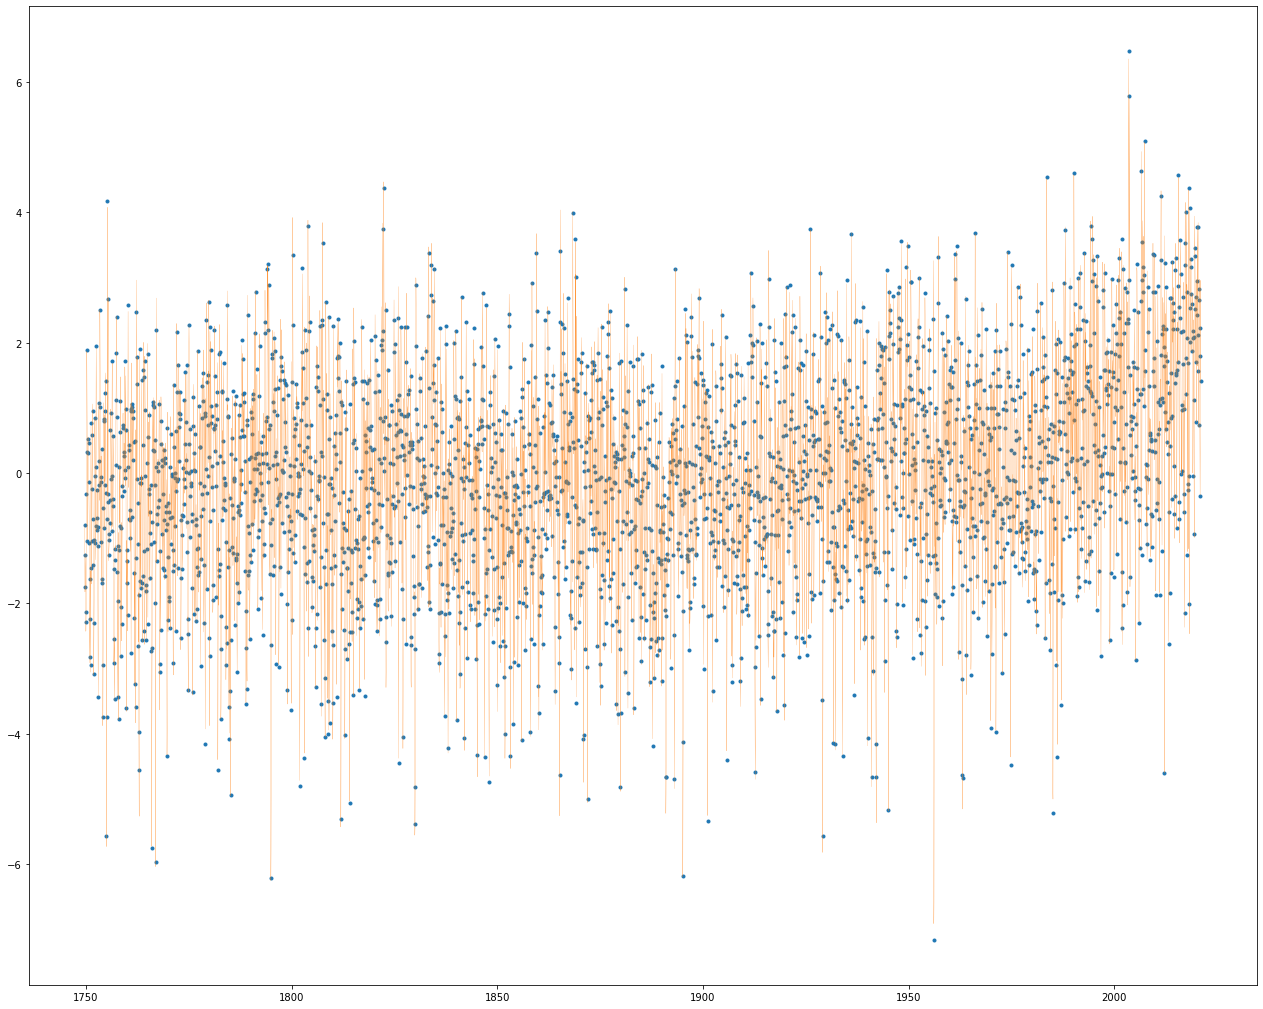

In [18]:
plt.figure(figsize=(22,18))
plt.plot(x, y, '.', xnew, ynew, '-', linewidth = 0.2)
plt.show()

# 1. Trend

$z_t = x_t + y_t$

Avec :

- $z_t$ l'anomalie de température au temps $t$ ;
- $x_t$ la partie déterministe ;
- $y_t$ la partie stochastique ; 

## 1.1. Linear Regression

Ainsi nous allons essayer d'utiliser la régression linéaire en créant 4 modèles (constant, linéaire, quadratique et cubique) afin d'expliquer au mieux nos données.

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
X = xnew.reshape(len(xnew), 1)
Y = ynew.reshape(len(ynew), 1)

### 1. Constant regression :

In [21]:
regr0 = [np.mean(ynew) for i in range(len(xnew))]

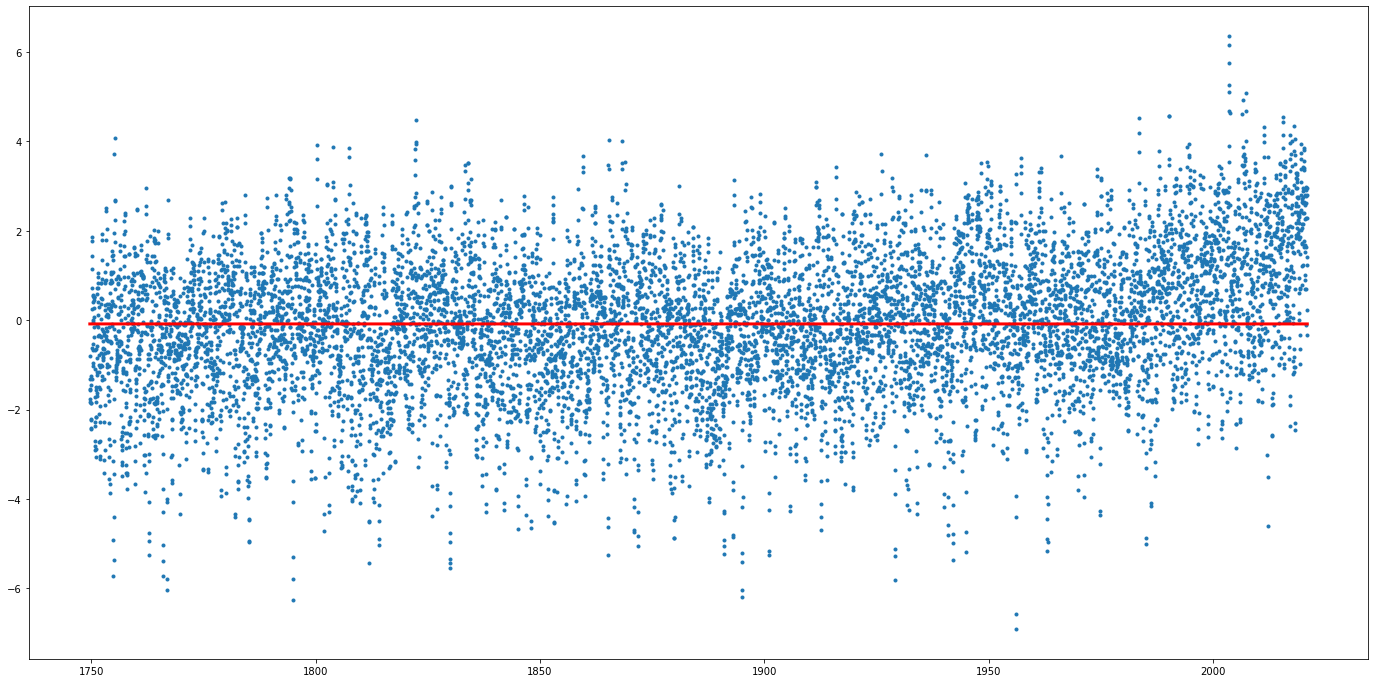

In [22]:
plt.figure(figsize=(24, 12))
plt.scatter(X, Y, marker='.')
plt.plot(X, regr0, color = 'red', linewidth = 3)
plt.show()

### 2. Linear Regression :

In [23]:
regr1 = LinearRegression()
regr1.fit(X, Y)

LinearRegression()

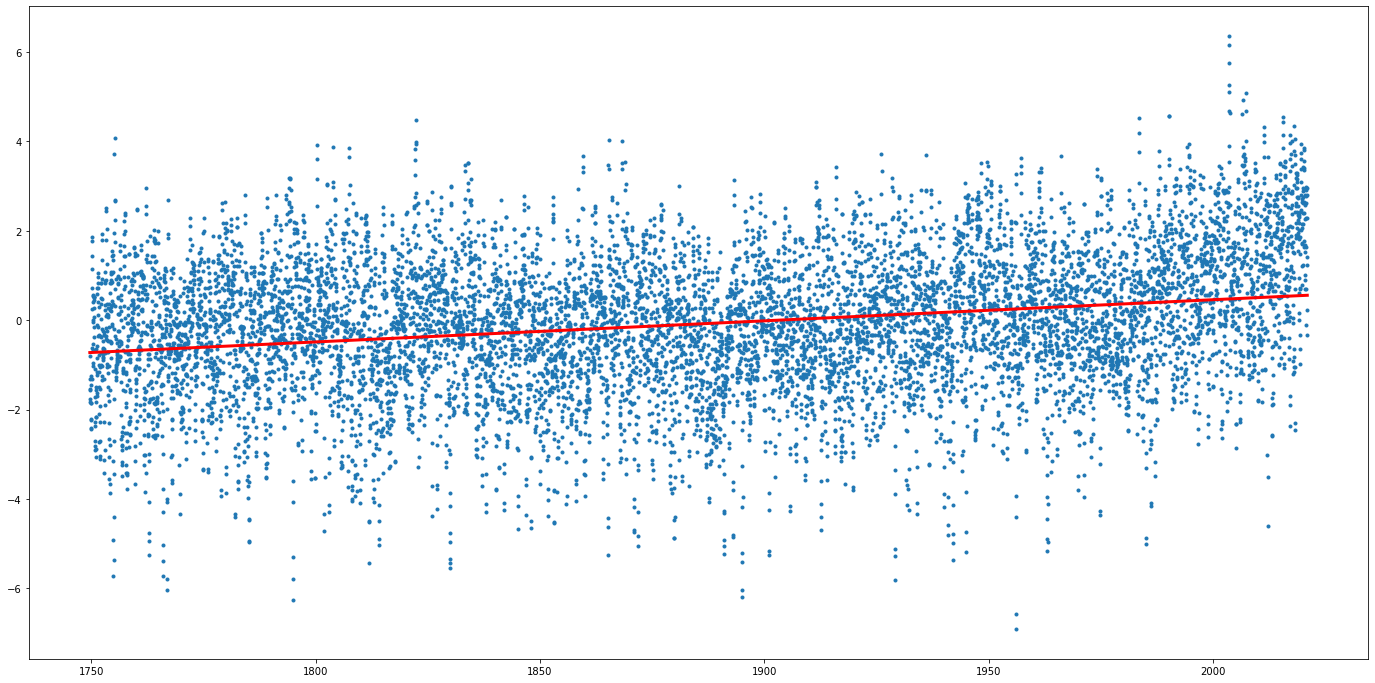

In [24]:
plt.figure(figsize=(24, 12))
plt.scatter(X, Y, marker='.')
plt.plot(X, regr1.predict(X), color = 'red', linewidth = 3)
plt.show()

### 3. Quadratic regression :

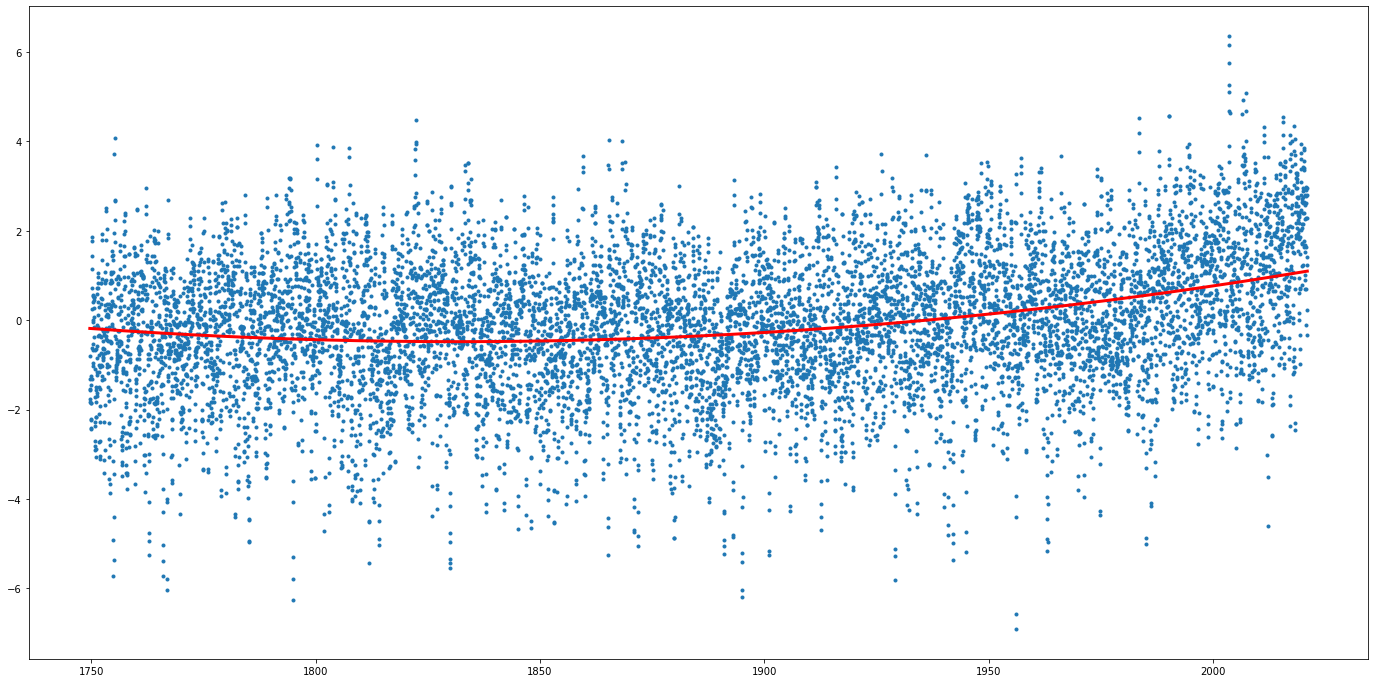

In [25]:
p2 = np.poly1d(np.polyfit(xnew, ynew, 2))
plt.figure(figsize=(24, 12))
plt.scatter(X, Y, marker='.')
plt.plot(xnew, p2(xnew), c='r', linewidth = 3)
plt.show()

In [26]:
print(p2) # Our trinome equation 

           2
4.402e-05 x - 0.1613 x + 147.2


### 4. Cubic regression :

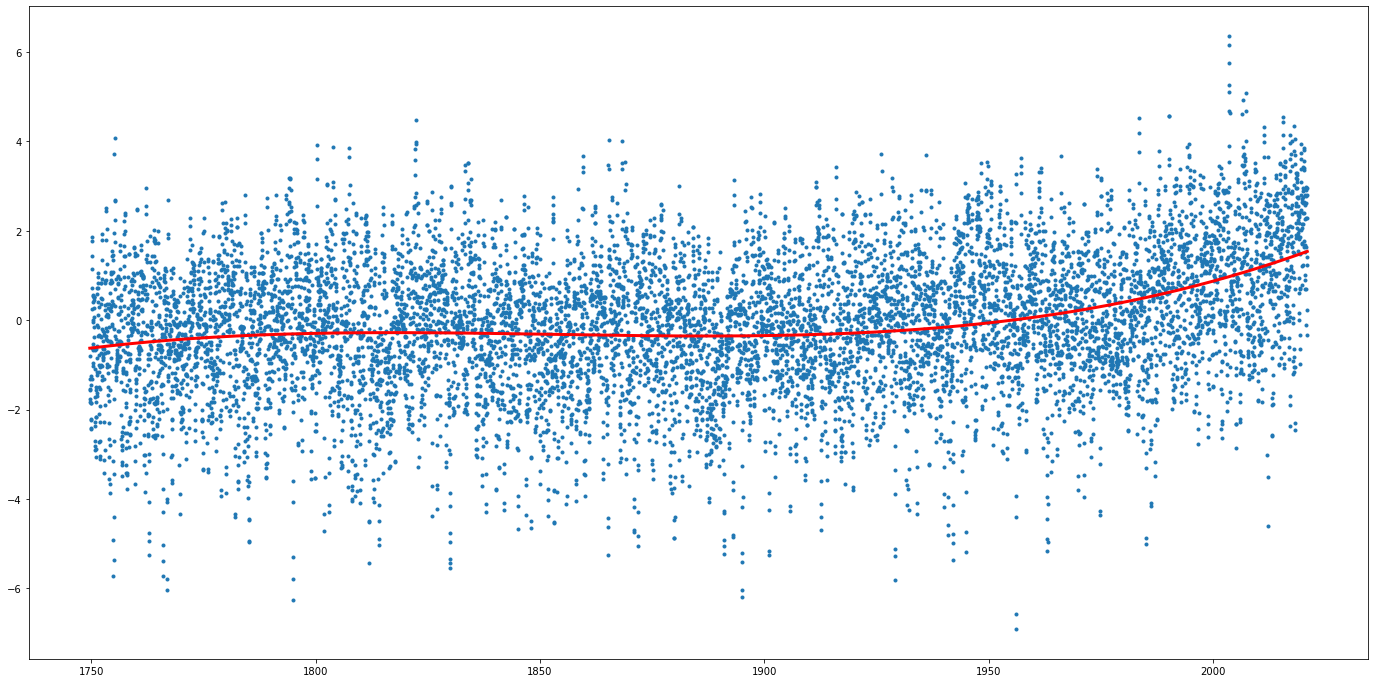

In [27]:
p3 = np.poly1d(np.polyfit(xnew, ynew, 3))
plt.figure(figsize=(24, 12))
plt.scatter(X, Y, marker='.')
plt.plot(xnew, p3(xnew), c='r', linewidth = 3)
plt.show()

### 5. 5th degrees regression

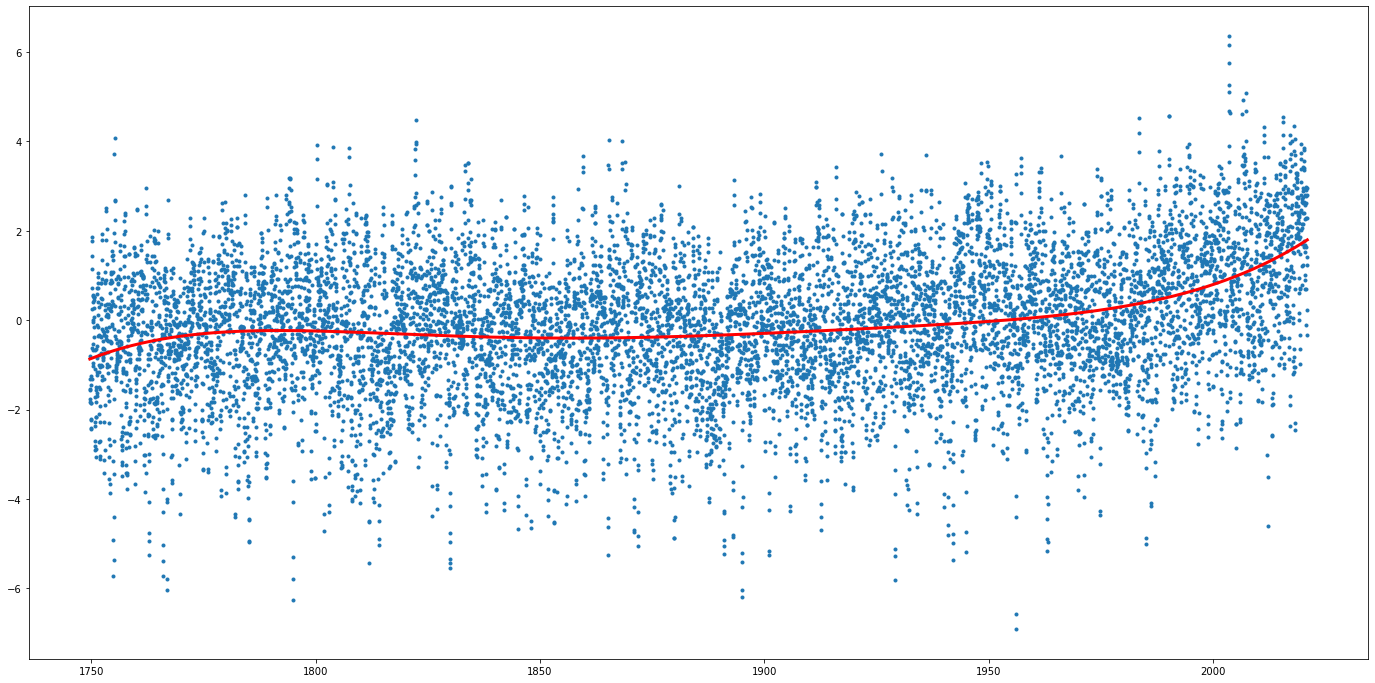

In [28]:
p5 = np.poly1d(np.polyfit(xnew, ynew, 5))
plt.figure(figsize=(24, 12))
plt.scatter(X, Y, marker='.')
plt.plot(xnew, p5(xnew), c='r', linewidth = 3)
plt.show()

## 1.2. SSE and R2 scores

In [29]:
from sklearn.metrics import r2_score

In [30]:
def SSE (Y, Y_pred):
    sse = 0
    for i in range(len(Y)):
        sse += (Y[i] - Y_pred[i])**2
    return (sse)

In [31]:
sse0 = SSE(ynew, regr0)
sse1 = int(SSE(ynew, regr1.predict(X)))
sse2 = SSE(ynew, p2(xnew))
sse3 = SSE(ynew, p3(xnew))
sse5 = SSE(ynew, p5(xnew))
print(sse0, sse1, sse2, sse3, sse5)

24293.155016091703 22923 22340.250014228237 22061.266643139094 22004.293672586657


In [32]:
r2_0 = r2_score(Y, regr0)
r2_1 = r2_score(Y, regr1.predict(X))
r2_2 = r2_score(ynew, p2(xnew))
r2_3 = r2_score(ynew, p3(xnew))
r2_5 = r2_score(ynew, p5(xnew))
print(r2_0, r2_1, r2_2, r2_3, r2_5)

0.0 0.056370594447296196 0.08038910551427958 0.09187313757616622 0.09421836488462831


Plus nous augmentons le degrès du polynome et mieux nous arrivons à expliquer nos données par une fonction. Pour le voir nous avons calculé des sommes des carrés des écarts et des coefficients de determination $R^2$ et nous voyons que plus le degrès du polynome augmente plus cette somme diminue.

Pour la suite du TP nous allons garder la régressions cubique qui est la plus appropriée des 4 régressions effectuées.

## 2. De-trended data

Dans cette partie nous allons essayer de trouver $y_t$ tel que $z_t - x_t = y_t$

In [33]:
y_detrended = ynew-p3(xnew)
print(np.mean(y_detrended)) # Very close to 0, That's what we wanted.

2.7379357447898655e-12


Nous pouvons donc voir que la moyenne de $y_t$ est très proche de $0$, ce qui est cohérent avec le fait que $y_t$ soit la partie stochastique de notre mesure d'anomalie. 

## 3. Power Spectral Density

La densité spectrale de puissance est la transformée de Fourier de la fonction d'autocorrélation et la fonction d'autocorrélation est la transformée de Fourier inverse de la densité spectrale de puissance.

In [34]:
def psd(x,dt):
    H = np.fft.fft(x)
    N = len(x)
    S = H*np.conjugate(H)/N
    f = 1/dt * np.arange(0,N)/N
    return f, S

In [35]:
f, S = psd(ynew, 0.25)

/home/nicolas/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


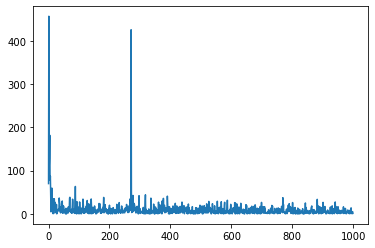

In [36]:
plt.plot(S[0:1000])
plt.show()

In [37]:
N = len(y_detrended)
N2 = int(N/2)+1
n  = range(N2) # this goes from 0 to N/2 if even, and from 0 to (N-1)/2 if odd

/home/nicolas/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


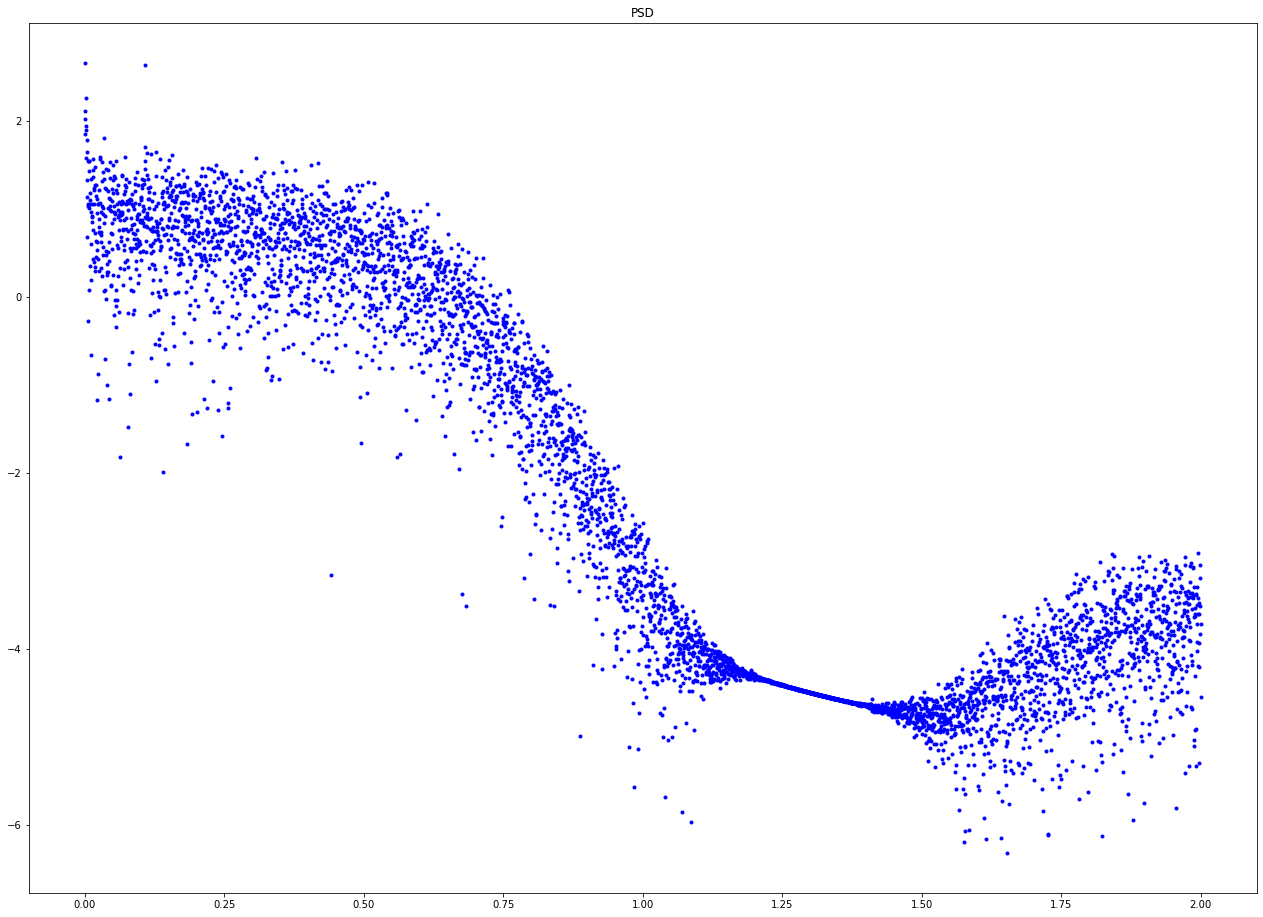

In [38]:
plt.figure(figsize=(22, 16))
plt.plot(f[n],np.log10(S[n]),'bo', marker = '.', linewidth = 0.5)
plt.title("PSD")
plt.show()

## 4. Auto-correlation

In [39]:
def autocorrel(S):
    return np.fft.ifft(S)

In [40]:
K = autocorrel(S)

In [48]:
print(np.real(K))
K_reel=list(np.real(K))

[2.43631955 2.1919664  1.58640698 ... 0.91218275 1.58640698 2.1919664 ]


/home/nicolas/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


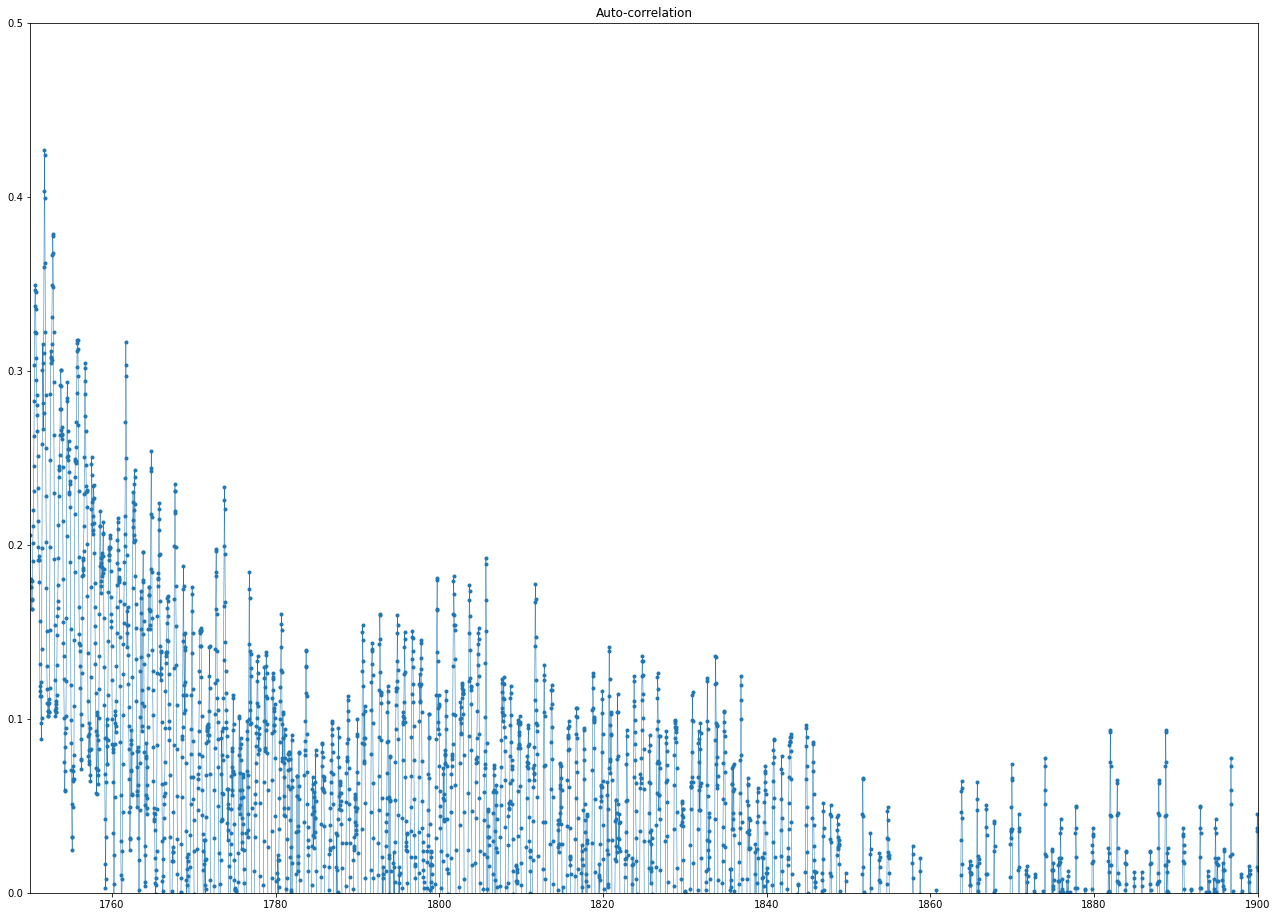

In [42]:
plt.figure(figsize=(22, 16))
plt.plot(xnew, K, marker = '.', linewidth = 0.5) # uncoment to plot the whole PSD
plt.xlim(1750,1900)
plt.ylim(0,0.5)
plt.title("Auto-correlation")
plt.show()

On observe des maximums locaux : donnent des tendances vers 23 ans, 46 ans ... Il semble y avoir des ocillations périodiques sur un période de 23 ans.

Pour le processus de température, il y a une périodicité en fonction des saisons. Par exemple, la corrélation entre hiver et hiver est positive et entre hiver et été, elle est négative. C'est bien ce que l'on observe ici avec un décalage sur l'axe des y qui fait que l'auto-corrélation est positive.

 ## 5. Modelling

Voici l'équation du processus d'Ornstein-Uhlenbeck : 
$\frac{\partial z}{\partial t} = -\theta \times (z - \mu) + \sigma \times W(t)$

In [43]:
def solve_OU(theta,mu,sigma,tfinal,x0,dt): # Ornstein-Uhlenbeck
    sqrt_dt = np.sqrt(dt)
    n = int(1 + tfinal/dt)
    x = np.zeros(n)
    t = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        x[i+1] = x[i] + dt*( theta*(x[i] - mu) ) + sqrt_dt*sigma*(x[i])*np.random.randn()
        t[i+1] = t[i] + dt
    return x, t

Il faut qu'on estime les paramètres suivants : $\mu$, $\sigma$ et $\theta$.
Pour $\mu$, il s'agit de la moyenne sur le long terme du processus d'Ornstein-Uhlebeck.
Par contre, pour les autres paramètres, nous devons êtres plus astucieux.
En effet, on sait que l'auto-corrélation se définit comme ceci : 
A= $\frac{\sigma^2}{2*\theta}*exp(-\theta * |\tau|)$.
ln(A)= $ln(\frac{\sigma^2}{2*\theta})-\theta * |\tau|$.
Essayons alors de fitter notre courbe à cette droite.


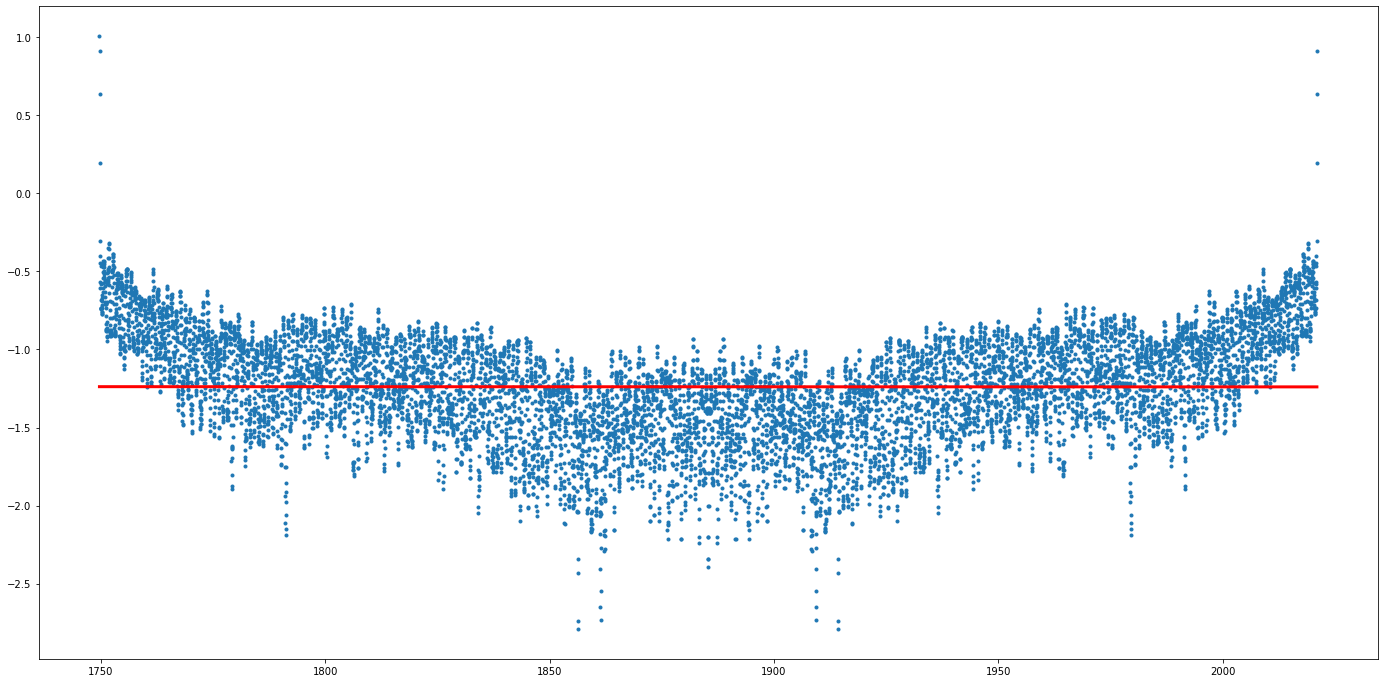

In [44]:
K_reel_bis=[K_reel[i]+0.3 for i in range(len(K_reel))]
p1 = np.poly1d(np.polyfit(xnew, np.log(K_reel_bis), 1))
plt.figure(figsize=(24, 12))
plt.scatter(xnew, np.log(K_reel_bis), marker='.')
plt.plot(xnew, p1(xnew), c='r', linewidth = 3)
plt.show()

In [45]:
print(p1)

 
-4.965e-06 x - 1.229


On a donc l'ordonnée à l'origine et le coefficient directeur de notre fit. On sait alors que le coefficient directeur a vaut : -$\theta$ et l'ordonnée à l'origine b vaut $ln(\frac{\sigma^2}{2*\theta})-0.3$ (car on a décalé les valeurs de 0.3 pour qu'elles soient définies pour ln).
L'équation de la droite devient donc : -2.726e-06 x - 0.2933
Ainsi,

1.   $\theta$ = $-a$
2.   $\sigma$ = $\sqrt{exp(b)*2*\theta}$





Dans notre cas, $\theta$ vaut donc : 2.726e-06 et $\sigma$ vaut  : 2e-3

In [46]:
z, t = solve_OU(theta=2.72e-6, mu=np.mean(ynew), sigma=2e-3, tfinal=2, x0=0, dt=0.25)

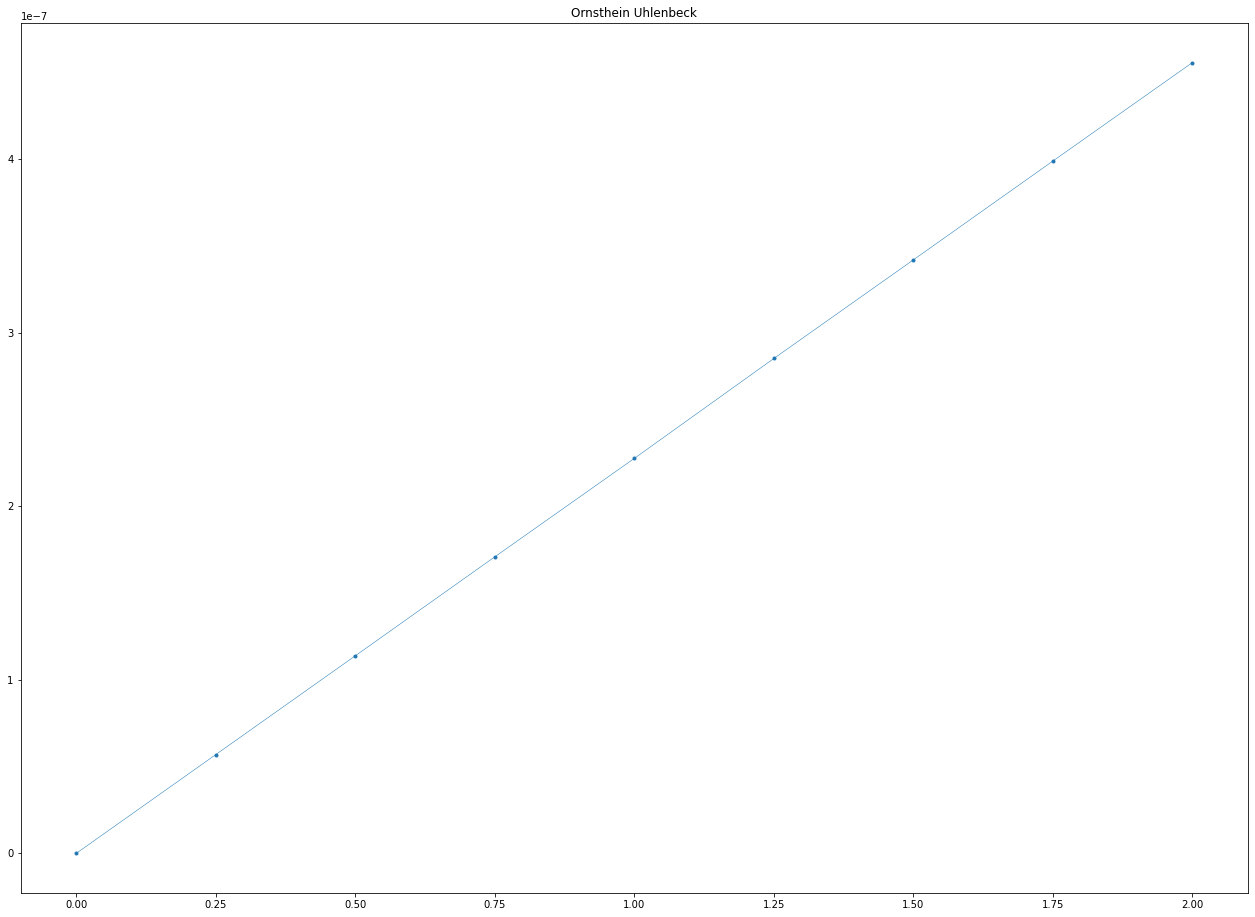

In [47]:
plt.figure(figsize=(22, 16))
plt.plot(t, z, marker = '.', linewidth = 0.5) # uncoment to plot the whole PSD
plt.title("Ornsthein Uhlenbeck")
plt.show()

Une autre approche, celle que l'on a vu en cours, est de comparer les autocorrelations de notre processus et des données détrendées : on aurait remarqué que les allures des autocorerelations et des données détrendées sont très différentes : on va faire dépendre sigma de t, et on veut que le coefficient "b" soit périodique : ex : un sinus avec par exemple 2pi/23 (où 23 est la période), et on va mettre une constante devant. On garde sigma constant.
On plot et on ajuste les coefficients pour avoir les mêmes allures de courbes.